# Proyecto Final: Combinación de Tipos de Neuronas.

_Jorge III Altamirano Astorga, Luz Aurora Hernández Martínez, Ita-Andehui Santiago Castillejos._

Se combinarán en este notebook los tipos de neuronas que utilizamos en los modelos basados en:

* [Datos del Sensor](proyectofinal02_secuencial.html).

* [Datos del Sensor + Datos Estaciones de Monitoreo](proyectofinal03_sensor-sinaica.html).

Todos manejados como una serie de tiempo secuencial.

In [1]:
import re, os, sys, shelve, time, dill, io
from pickle import PicklingError
from dill import Pickler, Unpickler
shelve.Pickler = Pickler
shelve.Unpickler = Unpickler
from IPython.display import display, Markdown, Math, clear_output, Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
from tqdm.keras import TqdmCallback
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, \
  SimpleRNN, Input, Conv1D, Flatten
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
tf.get_logger().setLevel('ERROR')

try:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=False)
  from google.colab import files
except:
  ;

base_url = ""
# File Loaders
try:
    base_url = "drive/MyDrive/Colab Notebooks/proyecto-final"
    uploaded = os.path.join(base_url, "data/sinaica-imputated.pickle.gz")
    if(not os.path.isfile(uploaded)):
        from google.colab import files
        uploaded = files.upload()
except:
    uploaded = "sinaica-imputated.pickle.gz"

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    """
    Taken from https://stackoverflow.com/a/39358722/7323086
    """
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w', size=font_size*1.05)
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    plt.show()

#df.dropna(inplace=True)
clear_output()

def performance_plot(history, a=None, b=None, 
                    metrics=["accuracy", "val_accuracy"],
                    plot_validation=True,
                    title="Gráficas de Desempeño."):
  """
  Prints performance plot from a, to b on a history dict.
  
  Inputs:
  history: dict containing "loss" and "accuracy" keys
  a: epoch start
  b. last epoch
  metrics: plot these metrics (train and validation). Always 2.
  plot_validation: boolean indicating if validation data should be plotted.
  a: from this epoch
  b: to this epoch    
  """
  if a is None:
      a = 0
  if b is None:
      b = len(history['loss'])
  a = np.min((a,b))
  b = np.max((a,b))

  imgrows = (len(metrics) + 1) / 2
  imgrows = np.round(imgrows, 0)
  imgrows = int(imgrows)
  #print(imgrows)

  # Plot loss
  plt.figure(figsize=(14, 5
                      *imgrows))
  plt.suptitle(title)
  plt.subplot(imgrows, 2, 1)
  plt.title('Loss')
  plt.plot(history['loss'][a:b], label='Training', linewidth=2)
  if plot_validation:
    plt.plot(history['val_loss'][a:b], label='Validation', linewidth=2)
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel(f'Loss')
  quantiles = np.quantile(range(a, b), 
                          [.2, .4, .6, .8]).round(0).astype(int)
  quantiles = np.insert(quantiles, 0, [a])
  quantiles += 1
  quantiles = np.append(quantiles, [b-1])
  plt.xticks(ticks=quantiles-a,
              labels=quantiles)
  plt.grid(True)

  # Plot accuracy
  for i, metric in enumerate(metrics): 
    #print(f"metric: {metric}, i: {i}")
    #print(f"mean metric: {np.mean(history[metric])}")
    plt.subplot(imgrows, 2, i+2)
    plt.title(metric)
    plt.plot(history[metric][a:b], label='Training', 
              linewidth=2)
    if plot_validation:
      plt.plot(history["val_" + metric][a:b], 
                label='Validation', linewidth=2)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    #plt.xlim(a, b)
    #print(range(0, b-a))
    plt.xticks(ticks=quantiles-a, 
                labels=quantiles)
    plt.grid(True)

  plt.show()

#render_mpl_table(df.head().applymap(shorten), col_width=5)

sinaica = pd.read_pickle(uploaded)
airdata = pd.read_pickle(os.path.join(base_url, "data/air-imputated.pickle.gz"))
#sinaica.head()

## Preparación de los Datos

Excluimos las columnas del modelo dado que presentan:
* Data leakage: "IAQ", "gasResistance", dado que son la misma variable, 
  transformada; así mismo iaqAccuracy es una variable de la calidad
  de la respuesta.
* Replicabilidad: no se va a repetir la fecha y vamos a buscar predicciones a futuro. Por ende excluimos datetime, year.
* Utilidad: consideramos las siguientes columnas que no son útiles en esta fase: datetime-1, imputated.


### Separación de Sets Entrenamiento, Pruebas

Separamos los sets  de entrenamiento  y pruebas para evaluar los modelos que realizamos.

In [2]:
excluded_columns = ["iaqAccuracy", "datetime", "datetime-1", "delta", 
                    "imputated", "year"]
train, test = train_test_split(sinaica[[x 
                                        for x in sinaica.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
display(Markdown(f"* Observaciones en el set de entrenamiento: \
{train.shape[0]:3,} ({100*train.shape[0]/sinaica.shape[0]:.2f}%)."))
display(Markdown(f"* Observaciones en el set de pruebas: \
{test.shape[0]:3,} ({100*test.shape[0]/sinaica.shape[0]:.2f}%)."))

* Observaciones en el set de entrenamiento: 984,731 (70.00%).

* Observaciones en el set de pruebas: 422,029 (30.00%).

### Escalamos los Datos

In [3]:
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]
display(
    Markdown(f"X_train.shape = {X_train.shape}, Y_train.shape = {Y_train.shape}."
    )
)
display(
    Markdown(f"X_test.shape = {X_test.shape}, Y_test.shape = {Y_test.shape}."
    )
)

X_train.shape = (984731, 15), Y_train.shape = (984731, 2).

X_test.shape = (422029, 15), Y_test.shape = (422029, 2).

In [4]:
def train_model(model, train_data,  validation_data,
                epochs=10, batch_size=512, 
                steps_per_epoch=100, loss='mse', optimizer='adam', 
                metrics=['mse'], verbose=0, base_dir=""):
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
  cbk = TqdmCallback()
  tiempo = time.time()
  history = model.fit(train_data, validation_data=validation_data,
                      epochs=epochs, steps_per_epoch=steps_per_epoch, 
                      batch_size=batch_size, verbose=verbose, callbacks=[cbk])
  clear_output()
  tiempo = time.time() - tiempo
  print(f"Tiempo de procesamiento: {tiempo:.2f} segundos.")

  #### Guardar el modelo
  base_dir = os.path.join(base_url, "models-sinaica", model.name)
  model.save(f"{base_dir}.h5")
  dill.dump(tiempo, open(f"{base_dir}.time.dill", 'wb'))
  dill.dump(history.history, open(f"{base_dir}.hist.dill", 'wb'))
  #### fin sección guardar modelo

  return history

# sampling_rate: 3 seconds per sample
sampling_rate = 3
# 1 hours * minutes * seconds / sampling_rate in seconds
past = int(1 * 60 * 60 / sampling_rate) 
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  batch_size=512,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:,1],
  sequence_length=past,
  sequence_stride=60*60,
  sampling_rate=60,
  batch_size=512,
  seed=175904
)

## Creación de un Modelo para los Datos del Sensor + Datos del Gobierno "SINAICA"

Intentaremos predecir nuestra variable de interés IAQ con el siguiente modelo:

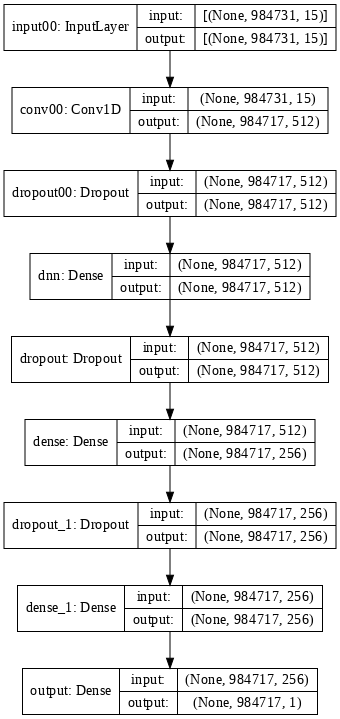

In [37]:
model_best01a = Sequential(name="model_best01a")
model_best01a.add(Input(shape=(X_train.shape[0], X_train.shape[1], ), 
                       name="input00"))
model_best01a.add(Conv1D(512, X_train.shape[1], activation='relu', name="conv00"))
model_best01a.add(Dropout(0.3, name="dropout00"))
model_best01a.add(Dense(units=512, activation='relu', name="dnn"))
model_best01a.add(Dropout(0.3))
model_best01a.add(Dense(units=256, activation='relu'))
model_best01a.add(Dropout(0.5))
model_best01a.add(Dense(units=256, activation='relu'))
model_best01a.add(Dense(units=1, activation=None, name="output"))
plot_model(model_best01a, to_file=os.path.join(base_url, "data/model.png"), 
           dpi=72, rankdir="TB", show_shapes=True, expand_nested=True)

In [ ]:
trained_model01a = train_model(model_best01a, train3_iaq,
                            validation_data=test3_iaq,
                            metrics=["mse", "mae", "mean_squared_logarithmic_error"],
                            epochs=100, steps_per_epoch=20, 
                            base_dir=base_url)

Tiempo de procesamiento: 593.46 segundos.


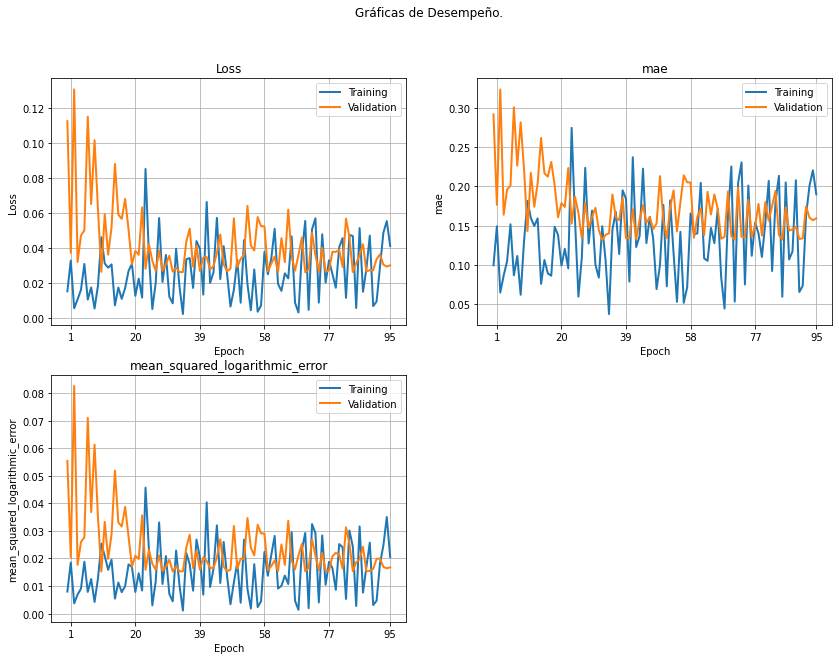

In [ ]:
performance_plot(trained_model01a.history, metrics=['mae', "mean_squared_logarithmic_error"])

## Combinación de Tipos de Neuronas: LSTM + CNN

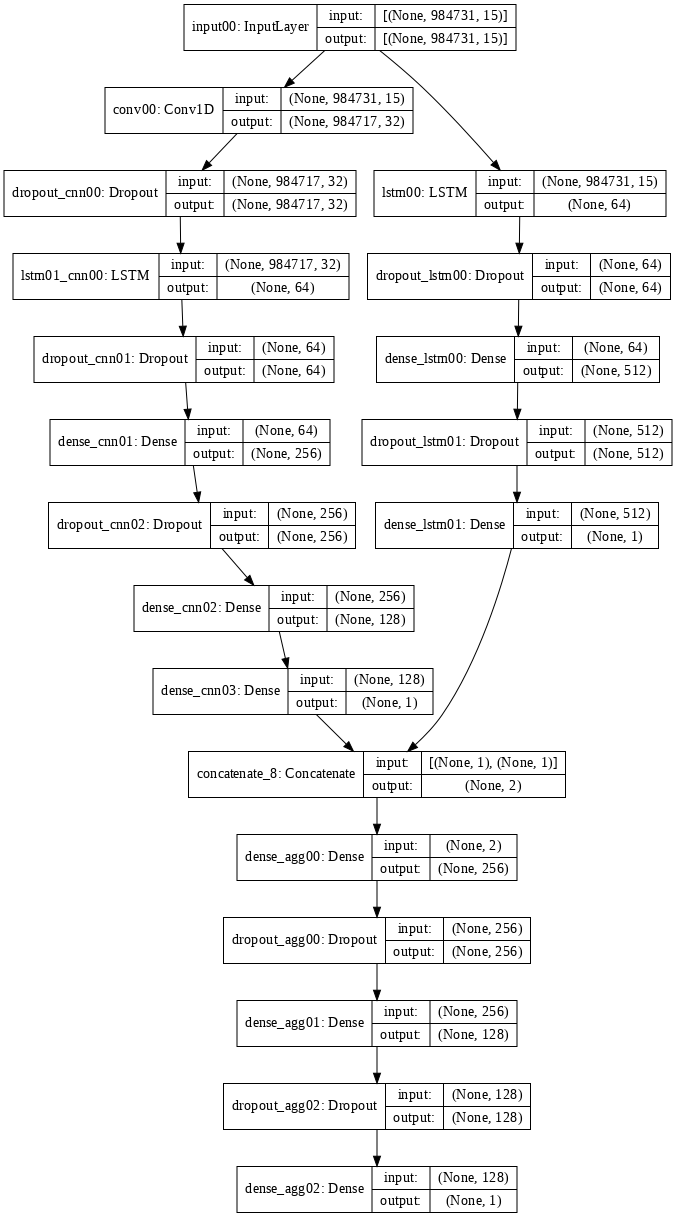

In [29]:
input00 = Input(shape=(X_train.shape[0], X_train.shape[1],), name="input00")  

# LSTM Section
lstm00 = LSTM(units=64, name="lstm00")(input00)
lstm00 = Dropout(0.2, name="dropout_lstm00")(lstm00)
lstm00 = Dense(512, name="dense_lstm00", activation='relu')(lstm00)
lstm00 = Dropout(0.2, name="dropout_lstm01")(lstm00)
lstm00 = Dense(1, name="dense_lstm01")(lstm00)

# Convolutional Section
conv00 = Conv1D(32, X_train.shape[1], activation='relu', name="conv00")(input00)
conv00 = Dropout(0.5, name="dropout_cnn00")(conv00)
conv00 = LSTM(units=64, name="lstm01_cnn00")(conv00)
conv00 = Dropout(0.5, name="dropout_cnn01")(conv00)
#conv00 = Dense(512, name="dense_cnn00")(conv00)
conv00 = Dense(256, name="dense_cnn01", activation='relu')(conv00)
conv00 = Dropout(0.5, name="dropout_cnn02")(conv00)
conv00 = Dense(128, name="dense_cnn02", activation='relu')(conv00)
#conv00 = tf.keras.layers.Flatten(name="flatten_cnn00")(conv00)
conv00 = Dense(1, name="dense_cnn03")(conv00)

# Merge all available features into a single large vector via concatenation
concat00 = tf.keras.layers.concatenate([lstm00, conv00])

# Stick a logistic regression for priority prediction on top of the features
pred = Dense(256, name="dense_agg00")(concat00)
pred = Dropout(0.5, name="dropout_agg00")(pred)
pred = Dense(128, name="dense_agg01")(pred)
pred = Dropout(0.5, name="dropout_agg02")(pred)
pred = Dense(1, name="dense_agg02")(pred)

# Instantiate an end-to-end model predicting both priority and department
model_best01b = Model(
    inputs=[input00],
    outputs=[pred],
    name="model_best01b"
)
plot_model(model_best01b, to_file=os.path.join(base_url, "data/model.png"), 
           dpi=72, rankdir="TD", show_shapes=True, expand_nested=True)

In [22]:
trained_model01b = train_model(model_best01b, train3_iaq,
                            validation_data=test3_iaq,
                            metrics=["mse", "mae", "mean_squared_logarithmic_error"],
                            epochs=100, steps_per_epoch=20, 
                            base_dir=base_url)

Tiempo de procesamiento: 593.46 segundos.


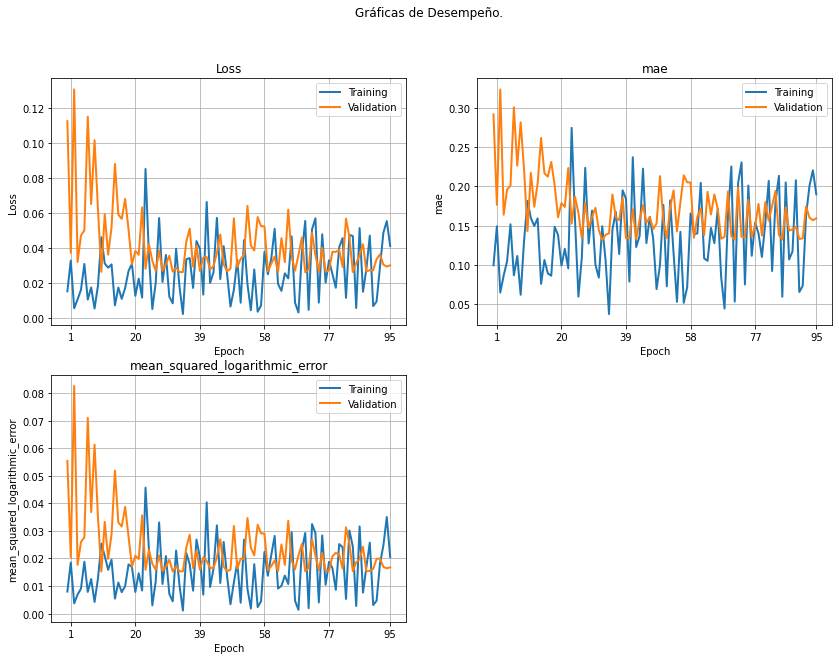

In [23]:
performance_plot(trained_model01b.history, metrics=['mae', "mean_squared_logarithmic_error"])

In [35]:
models = []
object_names = []
models_path = os.path.join(base_url, "models-sinaica")

for y in [x for x in os.listdir(models_path) if x.endswith("dill")]:
  model_path = os.path.join(models_path, y)
  with io.open(model_path, 'rb') as file:
      object_name = re.sub(r"\.", "_", y)
      object_name = re.sub(r"_dill", "", object_name)
      globals()[object_name] = dill.load(file)
      object_names.append(object_name)
display(Markdown("Objetos cargados: \n\n>" + 
         ", ".join(object_names)))


model_times = [o for o in object_names if o.endswith("_time")]
perf_table = pd.DataFrame({
  "Modelo": [re.sub("_time$", "", model_time) for model_time in model_times],
  "Tiempo": [globals()[model_time] for model_time in model_times]
})
model_histories = [o 
                   for o in object_names 
                   if o.endswith("_hist")
                  ]
model_metrics = [k 
                 for k in globals()[model_histories[0]].keys()
                 if re.search("^(val_|loss)", k) is None
                ]

for metric in model_metrics:
  perf_table["val_" + metric] = [np.mean(globals()[o]["val_" + metric]) for o in model_histories]
for metric in model_metrics:
  perf_table[metric] = [np.mean(globals()[o][metric]) for o in model_histories]
perf_table.rename({
  "mean_squared_logarithmic_error": "msle",
  "val_mean_squared_logarithmic_error": "val_msle"
}, axis=1, inplace=True)
perf_table.drop(["loss", "val_loss"], axis=1, inplace=True, errors='ignore')
perf_table.sort_values("val_mse", inplace=True)
perf_table["Tiempo"] = (perf_table["Tiempo"] // 60).astype('int').astype("str") + "m" + \
(perf_table["Tiempo"] % 60).round(3).apply(lambda x: f"{x:2.2f}") + "s"
perf_table.reset_index(inplace=True, drop=True)
#perf_table.round(4)
excluded_columns = ["iaqAccuracy", "datetime", "datetime-1", "delta", 
                    "imputated", "year"]
train, test = train_test_split(sinaica[[x 
                                        for x in sinaica.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.8, random_state=175904, shuffle=False)
scaler_iaq = MinMaxScaler().fit(train[["IAQ"]])
perf_data_iaq = scaler_iaq.inverse_transform(perf_table.select_dtypes("float64"))
#scaler_gr = MinMaxScaler().fit(train[["gasResistance"]])
#perf_data_gr = scaler_gr.inverse_transform(perf_table.select_dtypes("float64"))
perf_data_iaq = pd.DataFrame(perf_data_iaq, 
                             columns=perf_table.select_dtypes("float64").columns)
#perf_data_gr  = pd.DataFrame(perf_data_gr, 
#                             columns=perf_table.select_dtypes("float64").columns)
perf_data_iaq.insert(0, "Tiempo", perf_table["Tiempo"], )
#perf_data_gr.insert(0,  "Tiempo", perf_table["Tiempo"], )
perf_data_iaq.insert(0, "Modelo", perf_table["Modelo"], )
#perf_data_gr.insert(0,  "Modelo", perf_table["Modelo"], )
perf_data = perf_table.copy()
perf_data.sort_values("val_mse", inplace=True)
perf_data.reset_index(inplace=True, drop=True)
model_number_rows = [int(re.sub("[^0-9]", "", x)) for x in perf_table["Modelo"]]
#is_gr_row = [(x % 2) == 0 for x in model_number_rows]
is_iaq_row = [(x % 2) == 1 for x in model_number_rows]
#perf_data.iloc[is_gr_row] = perf_data_gr
perf_data.iloc[is_iaq_row] = perf_data_iaq
cols = ["Modelo", "Tiempo", "val_mae", "mae"]
perf_data.round(2)[cols]

Objetos cargados: 

>model_rnn01_time, model_rnn01_hist, model_rnn03_time, model_rnn03_hist, model_lstm01_time, model_lstm01_hist, model_lstm03_time, model_lstm03_hist, model_conv01_time, model_conv01_hist, model_conv03_time, model_conv03_hist, model_dnn01_time, model_dnn01_hist, model_dnn03_time, model_dnn03_hist, model_baseline01_time, model_baseline01_hist, model_best01a_time, model_best01a_hist, model_best01b_time, model_best01b_hist

,Modelo,Tiempo,val_mae,mae
0,model_best01b,9m53.46s,78.58,60.67
1,model_lstm01,2m24.19s,83.18,52.96
2,model_lstm03,6m13.69s,81.68,55.41
3,model_best01a,7m47.91s,94.32,51.98
4,model_baseline01,1m9.73s,90.47,61.12
5,model_conv01,2m53.16s,95.57,48.06
6,model_conv03,6m56.74s,102.19,46.67
7,model_dnn01,1m33.90s,123.23,61.76
8,model_rnn01,12m7.97s,145.06,116.66
9,model_dnn03,3m14.81s,190.37,196.80


In [36]:
perf_table

,Modelo,Tiempo,val_mse,val_mae,val_msle,mse,mae,msle
0,model_best01b,9m53.46s,0.041925,0.173660,0.023716,0.026872,0.134084,0.015582
1,model_lstm01,2m24.19s,0.046592,0.183815,0.025843,0.023449,0.117044,0.014137
2,model_lstm03,6m13.69s,0.047594,0.180515,0.026574,0.024777,0.122448,0.014549
3,model_best01a,7m47.91s,0.059281,0.208437,0.034258,0.021195,0.114876,0.012775
4,model_baseline01,1m9.73s,0.059458,0.199944,0.033954,0.031288,0.135065,0.017771
5,model_conv01,2m53.16s,0.067586,0.211206,0.036244,0.019773,0.106215,0.011824
6,model_conv03,6m56.74s,0.069584,0.225839,0.040902,0.019871,0.103147,0.011741
7,model_dnn01,1m33.90s,0.120246,0.272323,0.053803,0.030206,0.136476,0.018148
8,model_rnn01,12m7.97s,0.166320,0.320564,0.061967,0.158804,0.257802,0.045507
9,model_dnn03,3m14.81s,0.323148,0.420703,0.098303,0.362164,0.434908,0.085765


# Referencias

* Keras contributors et al. [Keras / Code examples / Timeseries / Timeseries forecasting for weather prediction](https://keras.io/examples/timeseries/timeseries_weather_forecasting/). 2021.

* Tensorflow Contributors. [Tensorflow: Tutorial on Time series forecastingTime series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_serieshttps://www.tensorflow.org/tutorials/structured_data/time_series). 2021.

* Román-Rangel, Francisco. Notas y Código del Curso de Aprendizaje Profundo. 2021.

* González-Pérez, Felipe. [Notas de aprendizaje de máquina (2020)](https://lucid-torvalds-517e78.netlify.app/)

* Keras contributors et al. [Keras API Reference: fit](https://keras.rstudio.com/reference/fit.html). 2021.

* Keras contributors et al. [Keras API Reference: train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). 2021.

* Keras contributors et al. [Keras API Reference: timeseries_dataset_from_array](https://keras.io/api/preprocessing/timeseries/). 2021.